### Pairs Trading - Cointegration

**Motivation:**
- Security A - (Something Correlated to it) is more mean-reverting. Similar securties should trade similarily. Hence, any discrepancies between the correlated pairs should converge
- When there is a discrepancy, we form a long-short spread trade and bet on the discrepancy converging
- Pairs trading is one of the most popular statistical arbitrage strategies in traditional markets. We want to test the performance of this strategy in the cryptocurrency market, as it is still relatively new and should be fertile grounds for finding market inefficiencies
- We will use cointegration to find similar pairs as it is a robust statistical approach for identifying long-term equilibrium relationships between assets

In [1]:
from datetime import datetime
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from joblib import Parallel, delayed
from itertools import combinations

### Step 0: Data 
We selected the top 1,000 currencies sorted by volume from CoinGecko. Then, we filtered out coins with fewer than 90% of daily price data points between 2018 and 2024.

In [2]:
from_pickle = pd.read_pickle('../../data/CoinGecko_px_vol_1D.pkl')

In [3]:
price_columns = [col for col in from_pickle.columns if 'price' in col]
crypto_px = from_pickle[price_columns]
crypto_px.columns = crypto_px.columns.droplevel(1)

In [4]:
crypto_px = crypto_px.loc['2018-01-01':]
crypto_px = crypto_px.drop(columns=['TUSD', 'DAI', 'WBTC', 'WETH', 'USDC', 'BSV'])

In [5]:
# Calculate the total number of data points
total_data_points = len(crypto_px)

# Calculate the number of non-NA/null entries for each coin
non_null_counts = crypto_px.notnull().sum()

# Calculate the threshold for 90% of the data points
threshold = 0.90 * total_data_points

# Filter out columns with fewer than 90% of data points
crypto_px = crypto_px.loc[:, non_null_counts >= threshold]

crypto_px

,BTC,XRP,BNB,DOGE,ADA,TRX,LTC,LINK,BCH,EOS,...,UTK,PIVX,SYS,REQ,FUN,VIB,NULS,IDEX,MDT,BORG
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,14093.606831,2.310120,8.828099,0.009091,0.747140,0.051654,230.462120,0.751033,2426.970077,7.672278,...,0.467207,10.689500,0.783623,0.867352,0.086325,0.455327,2.267259,NaN,NaN,NaN
2018-01-02,15321.932852,2.455290,9.090393,0.009335,0.807430,0.080893,255.048185,0.689388,2627.026940,9.504036,...,0.647065,11.555000,0.817777,0.809224,0.088933,0.464458,2.510494,NaN,NaN,NaN
2018-01-03,15583.885538,3.125710,9.886323,0.009592,1.075401,0.098107,248.042194,0.704623,2630.511811,10.090184,...,0.896774,10.923600,0.798803,0.795348,0.106564,0.584170,3.696732,NaN,NaN,NaN
2018-01-04,15976.365194,3.220050,9.675758,0.010098,1.179347,0.218139,244.834372,1.036826,2458.894372,11.713284,...,0.874131,10.581200,0.784280,0.826834,0.178514,0.698240,4.788923,NaN,NaN,NaN
2018-01-05,18336.922980,2.931380,16.488523,0.013841,1.077821,0.231673,254.138525,0.996575,2551.321685,9.673192,...,0.762206,9.951170,0.748309,0.761799,0.161191,0.585847,5.659994,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,58804.234500,0.552884,503.472306,0.100570,0.328140,0.127716,59.691360,10.012537,330.440521,0.467477,...,0.038229,0.193892,0.073564,0.090949,0.003115,0.057157,0.245821,0.032078,0.036722,0.170774
2024-08-13,59350.074333,0.568612,518.752217,0.107647,0.338874,0.126661,61.414267,10.561648,354.155288,0.500104,...,0.039951,0.204125,0.078151,0.094758,0.003233,0.058272,0.255234,0.033471,0.038736,0.168182
2024-08-14,60601.223178,0.576440,523.553455,0.106469,0.340317,0.128873,63.411783,10.577495,352.234629,0.507208,...,0.039211,0.203198,0.076065,0.094747,0.003273,0.058356,0.251570,0.033162,0.038288,0.171173


We have 86 coins and will select pairs from among them.

In [6]:
# Daily returns
coins_ret = crypto_px / crypto_px.shift() - 1

In [7]:
end_of_insample = pd.Timestamp('2021-12-31')

# in-sample price
in_sample_px = crypto_px.loc[:end_of_insample]

In [8]:
def compute_turnover(port):
    to = (port.fillna(0)-port.shift().fillna(0)).abs().sum(1)   
    return to

In [9]:
def compute_sharpe_ratio(rets):
    mean_rets = rets.mean()*252
    vol = rets.std()*np.sqrt(252)
    sharpe_ratio = mean_rets / vol
    return sharpe_ratio

In [10]:
def compute_stats(rets):
    stats={}
    stats['avg'] = rets.mean()*252
    stats['vol'] = rets.std()*np.sqrt(252)
    stats['sharpe'] = stats['avg']/stats['vol']
    stats['hit_rate'] = rets[rets>0].count() / rets.count()
    stats = pd.DataFrame(stats)
    return stats

In [11]:
# def drawdown(px):
#     return (px / (px.expanding(min_periods=1).max()) - 1)
def drawdown(returns):
    """
    Calculate the drawdown series from the return series.
    
    Parameters:
    - returns: Series of returns (e.g., daily returns) for the strategy.
    
    Returns:
    - drawdown: Series of drawdowns over time.
    """
    # Calculate cumulative returns
    cumulative = (1 + returns).cumprod()

    # Calculate the running maximum
    running_max = cumulative.cummax()

    # Calculate drawdown
    drawdown = (cumulative - running_max) / running_max

    return drawdown

In [12]:
def duration(px):
    peak = px.expanding(min_periods=1).max()
    res = pd.DataFrame(index=px.index,columns=px.columns)
    for col in px.columns:
        for dt in px.index:
            if px.loc[dt,col] >= peak.loc[dt,col]:
                 res.loc[dt,col] = 0
            else: 
                res.loc[dt,col] = res.loc[:dt,col].iloc[-2] + 1
    return res

In [13]:
def plot_with_signals(log_px_i, log_px_j, z_score, exit_threshold=0.5):
    # Define entry signals (when z_score crosses ±1)
    buy_signals_i = (z_score < -1)
    sell_signals_i = (z_score > 1)
    buy_signals_j = (z_score > 1)
    sell_signals_j = (z_score < -1)

    # Define exit signals (when z_score moves back within exit_threshold)
    exit_signals_i = (z_score > -exit_threshold) & (z_score < exit_threshold)
    exit_signals_j = (z_score > -exit_threshold) & (z_score < exit_threshold)

    plt.figure(figsize=(14, 8))

    # Plot log prices
    plt.plot(log_px_i.index, log_px_i, label='Log Price of Asset i', color='blue', linewidth=1.5)
    plt.plot(log_px_j.index, log_px_j, label='Log Price of Asset j', color='orange', linewidth=1.5)

    # Plot z-score
    plt.plot(z_score.index, z_score, label='Z-score', color='grey', linestyle='--', linewidth=1.2)

    # Plot buy and sell signals for asset i
    plt.plot(log_px_i.index[buy_signals_i], log_px_i[buy_signals_i], '^', color='green', label='Buy Signal for Asset i', markersize=4, linestyle='None')
    plt.plot(log_px_i.index[sell_signals_i], log_px_i[sell_signals_i], 'v', color='red', label='Sell Signal for Asset i', markersize=4, linestyle='None')

    # Plot buy and sell signals for asset j
    plt.plot(log_px_j.index[buy_signals_j], log_px_j[buy_signals_j], '^', color='green', label='Buy Signal for Asset j', markersize=4, linestyle='None')
    plt.plot(log_px_j.index[sell_signals_j], log_px_j[sell_signals_j], 'v', color='red', label='Sell Signal for Asset j', markersize=4, linestyle='None')
        
    # Add labels and legend
    plt.title('Log Prices and Z-score with Entry and Exit Signals')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [14]:
def final_results(avg_return, volatility, sharpe, hit_rate, max_drawdown, max_duration, holding_period, IR):
    stats = {}
    stats['Return (Ann.)'] = f"{(avg_return * 100):.2f}%"  
    stats['Volatility (Ann.)'] = f"{(volatility * 100):.2f}%"  
    stats['Sharpe Ratio'] = f"{sharpe:.2f}"  
    stats['Hit Rate'] = f"{(hit_rate * 100):.2f}%"  
    stats['Max Drawdown'] = f"{(max_drawdown):.2f}%"  
    stats['Max Duration'] = f"{max_duration:.2f} days"  
    stats['Holding Period'] = f"{holding_period:.2f} days"  
    stats['Information Ratio'] = f"{IR:.2f}" 

    stats_df = pd.DataFrame(stats, index=['strategy']).T  
    return stats_df

### Step 1: Pairs Selection
The formation period is from January 1, 2018, to December 31, 2021. We use daily in-sample frequency to select pairs through the following steps:

1. **OLS Regression**: Perform Ordinary Least Squares (OLS) regression on the log prices of two securities to obtain the residuals.
   \$ \log(p_{i,t}) = \alpha + \beta \log(p_{j,t}) + \epsilon_t \$
  
2. **Stationarity Test**: Apply the Augmented Dickey-Fuller (ADF) test to the residuals to check for stationarity. A p-value < 0.05 suggests that the residuals are stationary.

#### Selection Criteria
Select the top pair with the most negative test statistic from the ADF test for each coin, ensuring all selected pairs have p-values less than 0.05.

In [15]:
def adf_for_pair(symbol_i, symbol_j, in_sample_px):
    """
    Perform the ADF test on the residuals of the OLS regression between two assets.

    Parameters:
    symbol_i (str): The first asset's symbol.
    symbol_j (str): The second asset's symbol.
    in_sample_px (DataFrame): The DataFrame containing in-sample price data for the assets.

    Returns:
    tuple: A tuple containing the pair (symbol_i, symbol_j) and a tuple of (p_value, test_statistic).
    """
    # Convert raw price to log price
    in_sample_log_px = np.log(in_sample_px)
    
    # Handle missing data
    X = in_sample_log_px[symbol_i].fillna(0).values
    Y = in_sample_log_px[symbol_j].fillna(0).values

    # OLS regression
    model = sm.OLS(Y, sm.add_constant(X)).fit()
    alpha = model.params[0]
    beta = model.params[1]
    residuals = Y - beta * X - alpha

    # ADF test on residuals
    adf_result = adfuller(residuals)
    p_value = adf_result[1]
    test_statistic = adf_result[0]
    
    return (symbol_i, symbol_j), (p_value, test_statistic)

In [16]:
def cointegration(in_sample_px, n_jobs=-1):
    """
    Compute ADF test results for all possible pairs of assets.

    Parameters:
    in_sample_px (DataFrame): DataFrame containing in-sample prices of assets.
    n_jobs (int): Number of parallel jobs to run.

    Returns:
    DataFrame: DataFrame containing ADF test results for all pairs.
    """
    symbols = in_sample_px.columns.tolist()
    pairs = list(combinations(symbols, 2))

    # Parallel computation of ADF tests for all pairs
    adf_results = Parallel(n_jobs=n_jobs)(
        delayed(adf_for_pair)(symbol_i, symbol_j, in_sample_px) for symbol_i, symbol_j in pairs
    )

    # Create a DataFrame with ADF results
    pairs, results = zip(*adf_results)
    adf_df = pd.DataFrame(results, columns=['p_value', 'test_statistic'], index=pairs)
    adf_df = adf_df.sort_values(by='test_statistic')

    return adf_df

In [17]:
def pair_selection(adf_df, significance_level=0.05, top_n=1):
    """
    Select the top `n` cointegrated pairs for each individual coin.

    Parameters:
    adf_df (DataFrame): DataFrame containing ADF test results for all pairs.
    significance_level (float): The significance level threshold for p-values to select cointegrated pairs.
    top_n (int): The number of top pairs to select for each coin.

    Returns:
    dict: A dictionary where each key is a coin and each value is a DataFrame 
          containing the top `n` pairs with that coin.
    """
    # Filter pairs with p-values less than the significance level
    filtered_df = adf_df[adf_df['p_value'] < significance_level]
    
    # Initialize dictionary to store top pairs for each coin
    top_pairs_per_coin = {}

    # Iterate over all unique coins in the filtered pairs
    all_coins = set(sum([list(pair) for pair in filtered_df.index], []))
    for coin in all_coins:
        # Filter pairs where the coin is involved
        coin_pairs = filtered_df.loc[[(coin in pair) for pair in filtered_df.index]]
        
        # Sort the pairs by the ADF test statistic (smaller test statistic is better)
        sorted_pairs = coin_pairs.sort_values(by='test_statistic')
        
        # Select the top `n` pairs for this coin
        top_pairs = sorted_pairs.head(top_n)
        
        # Store the result
        top_pairs_per_coin[coin] = top_pairs

    return top_pairs_per_coin

In [18]:
def print_top_cointegrated_pairs(selected_cointegrated_pairs_per_coin):
   # Sort the coins alphabetically
    sorted_coins = sorted(selected_cointegrated_pairs_per_coin.keys())
    
    # Display the top cointegrated pairs for each coin
    for coin in sorted_coins:
        df = selected_cointegrated_pairs_per_coin[coin]
        top_coins = [pair[1] if pair[0] == coin else pair[0] for pair in df.index]
        print(f"Top cointegrated coins with {coin}: {top_coins}")

In [19]:
# Compute ADF test results for all pairs
adf_df = cointegration(in_sample_px)
print(adf_df)

# Select the top n cointegrated pairs for each coin
selected_cointegrated_pairs_per_coin = pair_selection(adf_df, significance_level=0.05, top_n=1)
print_top_cointegrated_pairs(selected_cointegrated_pairs_per_coin)

                 p_value  test_statistic
STMX  ARDR  6.265094e-09       -6.614248
      IOST  1.745421e-07       -5.991039
TRX   ARDR  3.525891e-07       -5.854503
STEEM CTXC  3.811222e-07       -5.839269
ONT   NULS  1.392020e-06       -5.581681
...                  ...             ...
AMB   REQ   9.515168e-01       -0.078725
NEO   GNO   9.560108e-01       -0.029644
BCH   GNO   9.844215e-01        0.485368
AMB   SYS   9.860765e-01        0.541327
DASH  GNO   9.908005e-01        0.750882

[3655 rows x 2 columns]
Top cointegrated coins with ADA: ['SBD']
Top cointegrated coins with ADX: ['XLM']
Top cointegrated coins with AMB: ['PIVX']
Top cointegrated coins with ANT: ['UQC']
Top cointegrated coins with ARDR: ['STMX']
Top cointegrated coins with ARK: ['STRAX']
Top cointegrated coins with BAT: ['DOGE']
Top cointegrated coins with BCH: ['SWFTC']
Top cointegrated coins with BLZ: ['STRAX']
Top cointegrated coins with BNB: ['NEO']
Top cointegrated coins with BORG: ['REN']
Top cointegrated coin

In [20]:
final_pairs = []

for i, (coin, df) in enumerate(selected_cointegrated_pairs_per_coin.items()):
    # Extract the index (pairs) from the DataFrame and add to final_pairs
    final_pairs.extend(df.index.tolist())
    
# Remove duplicates (since a pair might appear in more than one coin's top pairs)
final_pairs = list(set(final_pairs))

# Sort the final list of pairs alphabetically
final_pairs.sort()

print(f"Selected pairs: {final_pairs}")
print(f"Total number of pairs: {len(final_pairs)}")

Selected pairs: [('ADA', 'SBD'), ('ADX', 'UTK'), ('AMB', 'PIVX'), ('ANT', 'UQC'), ('ARK', 'STRAX'), ('BCH', 'SWFTC'), ('BLZ', 'STRAX'), ('BNB', 'BTG'), ('BNB', 'GNO'), ('BNB', 'MLN'), ('BNB', 'NEO'), ('BTC', 'SWFTC'), ('CTXC', 'STRAX'), ('DASH', 'SWFTC'), ('DCR', 'SWFTC'), ('DENT', 'STRAX'), ('DGB', 'SNT'), ('DGB', 'XEM'), ('DGB', 'ZIL'), ('DOGE', 'BAT'), ('ELF', 'STEEM'), ('ENJ', 'VIC'), ('ETC', 'BTG'), ('GFT', 'CTXC'), ('GLM', 'ICX'), ('GLM', 'PRO'), ('IOST', 'XVG'), ('LINK', 'NMR'), ('LRC', 'TRAC'), ('LTC', 'SWFTC'), ('MANA', 'OMG'), ('MANA', 'QTUM'), ('MANA', 'STORJ'), ('MED', 'XDC'), ('MKR', 'SWFTC'), ('ONT', 'LSK'), ('ONT', 'NULS'), ('ONT', 'PIVX'), ('POWR', 'REQ'), ('POWR', 'STMX'), ('PRO', 'MTL'), ('REN', 'BORG'), ('REN', 'BTG'), ('REQ', 'IDEX'), ('RLC', 'VIC'), ('SNX', 'QTUM'), ('STEEM', 'CTXC'), ('STMX', 'ARDR'), ('STMX', 'IOST'), ('SYS', 'REQ'), ('THETA', 'SBD'), ('TRX', 'ARDR'), ('TRX', 'EOS'), ('TRX', 'MDT'), ('TRX', 'RVN'), ('TRX', 'WAXP'), ('VGX', 'GAS'), ('VGX', 'XNO'),

### Step 2: Trading Strategy

For the backtesting period from January 1, 2022, to the present, we implement the following strategy to each selected pairs:

#### 1. Signal Generation

- **Residual Calculation:**

  $$
  \epsilon_t = \log(p_{i,t}) - (\beta_t \log(p_{j,t}) + \alpha_t)
  $$

  where:
  - $\log(p_{i,t})$ and $\log(p_{j,t})$ are the log prices of coins $i$ and $j$ at time $t$.
  - **$\beta_t$** is calculated as:

   $$
   \beta_t = \text{Corr}_{t} \times \frac{\text{Vol}_{j,t}}{\text{Vol}_{i,t}}
   $$


    with:
    - **$\text{Corr}_{t}$** is the 90-day rolling correlation between $\log(p_{i,t})$ and $\log(p_{j,t})$.
    - **$\text{Vol}_{i,t}$** and **$\text{Vol}_{j,t}$** are the 90-day rolling volatilities of $\log(p_{i,t})$ and $\log(p_{j,t})$, respectively.
  - **$\alpha_t$** is calculated as:

  $$
  \alpha_t = \mu_{\log(p_{j,t})} - \beta_t \cdot \mu_{\log(p_{i,t})}
  $$
  
  where:
  - $\mu_{\log(p_{j,t},90)}$ is the 90-day rolling mean of $\log(p_{j,t})$.
  - $\mu_{\log(p_{i,t},90)}$ is the 90-day rolling mean of $\log(p_{i,t})$.

  
- **Z-Score Calculation:**

  $$
  z_t = \frac{\epsilon_t - \mu_t}{\sigma_t}
  $$

  where:
  - $\mu_t$ is the 90-day rolling mean of the spread.
  - $\sigma_t$ is the 90-day rolling standard deviation of the spread.

#### 2. Portfolio Construction

- **Entry Signals:**
  - **Short** coin $i$ and **long** $\beta_t$ units of coin $j$ if $z_t > 1$.
  - **Long** coin $i$ and **short** $\beta_t$ units of coin $j$ if $z_t < -1$.

- **Exit Signals:**
  - Close the position when $z_t$ moves to any of the following thresholds:

    $$
    z_t \geq -\text{threshold} \quad \text{or} \quad z_t \leq \text{threshold}
    $$

    where threshold is one of the values: 0.1, 0.2, 0.5, or 0.7.

In [21]:
def gen_signals(px, pairs, window=90):
    signal_df = {}
    
    for pair in pairs:
        asset_i, asset_j = pair
        
        # Forward-fill missing values and replace zeros with NaNs
        px_i = px[asset_i].replace(0, np.nan).ffill()
        px_j = px[asset_j].replace(0, np.nan).ffill()
        
        # Apply log transformation
        log_px_i = np.log(px_i)
        log_px_j = np.log(px_j)
        
        # Calculate rolling covariance and variance 
        rolling_cov = log_px_i.rolling(window=window, min_periods=1).cov(log_px_j)
        rolling_var = log_px_i.rolling(window=window, min_periods=1).var()
        
        # Calculate beta and alpha
        beta = rolling_cov / rolling_var
        alpha = log_px_j.rolling(window=window).mean() - beta * log_px_i.rolling(window=window).mean()
        
        # Calculate spread for time t using beta and alpha
        spread = log_px_i - (beta * log_px_j + alpha)
        
        # Calculate rolling mean and standard deviation of the spread using data up to t
        spread_mean = spread.rolling(window=window, min_periods=1).mean()
        spread_std = spread.rolling(window=window, min_periods=1).std()
        
        # Calculate the z-score for time t using spread, mean, and std
        z_score = (spread - spread_mean) / spread_std
        
        # Store beta, alpha, spread, and z-score in a multi-level column DataFrame
        signal_df[(pair, 'beta')] = beta
        signal_df[(pair, 'alpha')] = alpha
        signal_df[(pair, 'spread')] = spread
        signal_df[(pair, 'z_score')] = z_score
    
    # Convert the dictionary to a DataFrame
    signal_df = pd.DataFrame(signal_df)
    
    return signal_df

In [22]:
def gen_port(signal_df, pairs, threshold=0.5):
    # Initialize a DataFrame with the same index and columns as crypto_px, filled with NaN
    pos = pd.DataFrame(index=signal_df.index, columns=in_sample_px.columns)
    for pair in pairs:
        asset_i, asset_j = pair
        # Access z-scores and betas for this pair
        z_scores = signal_df[(pair, 'z_score')]
        betas = signal_df[(pair, 'beta')]

        # Set positions based on z-scores
        pos.loc[z_scores > 1, asset_i] = -1  # Short one unit of asset_i
        pos.loc[z_scores < -1, asset_i] = 1  # Long one unit of asset_i
        pos.loc[(z_scores.abs() <= threshold), asset_i] = 0  # Exit signal

        pos.loc[z_scores > 1, asset_j] = betas  # Long beta units of asset_j
        pos.loc[z_scores < -1, asset_j] = -betas  # Short beta units of asset_j
        pos.loc[(z_scores.abs() <= threshold), asset_j] = 0  # Exit signal

    # Forward-fill missing values
    pos = pos.ffill()
    # Normalize to ensure a fully-invested portfolio
    pos = pos.divide(pos.abs().sum(axis=1), axis=0).fillna(0)
    return pos

### Step 3: Performance Evaluation

We evaluate the strategy's performance across four exit thresholds: 0.1, 0.2, 0.5, and 0.7. For each threshold, the following key metrics are calculated:

- **Sharpe Ratio**: Risk-adjusted return of the strategy.
- **Transaction Costs**: Average costs incurred due to trading.
- **Holding Period**: Average number of days a position is held.
- **Turnover**: Average daily proportion of the portfolio that is traded.
- **Annualized Return**: Average yearly return of the strategy.
- **Annualized Volatility**: Standard deviation of returns on an annual basis, indicating risk.

Cryptocurrencies can have commissions of ~7bps. While total slippage is unknown and will depend on the trader’s volume as well, let’s assume another 13 bps. So total all-in execution costs will be 20 bps for market-orders.

In [23]:
# Define the thresholds and initialize the arrays for storing metrics
thresholds = [0.1, 0.2, 0.5, 0.7]
metrics = {
    'Sharpe Ratio': np.zeros(len(thresholds)),
    'Return': np.zeros(len(thresholds)),
    'Volatility': np.zeros(len(thresholds)),
    'Holding Period': np.zeros(len(thresholds)),
    'Turnover': np.zeros(len(thresholds)),
    'Transaction Costs': np.zeros(len(thresholds)),
}

# Set the start of the out-of-sample period
start_of_out_sample = end_of_insample + pd.DateOffset(days=1)

# Loop over each threshold to calculate metrics
for i, threshold in enumerate(thresholds):
    # Generate signals
    signal_df = gen_signals(crypto_px, final_pairs, window=90)
    signal_df = signal_df.loc[start_of_out_sample:]
    
    # Generate portfolio
    port = gen_port(signal_df, final_pairs, threshold)
    
    # Calculate out-of-sample daily returns
    out_sample_ret = coins_ret.loc[start_of_out_sample:][port.columns]
    strat_gross_ret = (port.shift() * out_sample_ret).sum(1)
    
    # Calculate net returns
    to = compute_turnover(port)
    tcost_bps = 20  # (commissions + slippage)
    strat_net_ret = strat_gross_ret.subtract(to * tcost_bps * 1e-4, fill_value=0)
    
    # Compute Sharpe ratio
    sharpe_ratio = compute_sharpe_ratio(strat_net_ret)
    metrics['Sharpe Ratio'][i] = sharpe_ratio
    
    # Compute return 
    returns = strat_net_ret.mean()
    metrics['Return'][i] = returns
    
    # Compute volatility
    volatility = strat_net_ret.std()
    metrics['Volatility'][i] = volatility
    
    # Compute holding period (average number of days a position is held)
    metrics['Holding Period'][i] = 2/to.mean()
    
    # Store turnover
    metrics['Turnover'][i] = to.mean()
    
    # Compute transaction costs
    total_tcost = to * tcost_bps * 1e-4
    metrics['Transaction Costs'][i] = total_tcost.mean()
    
# Convert metrics to a DataFrame for easier visualization
metrics_df = pd.DataFrame(metrics, index=thresholds)

# Display the results
print(metrics_df)

     Sharpe Ratio    Return  Volatility  Holding Period  Turnover  \
0.1      1.303307  0.000713    0.008688       19.918467  0.100409   
0.2      1.503272  0.000824    0.008706       17.729815  0.112804   
0.5      1.482900  0.000902    0.009656       14.840894  0.134763   
0.7      1.299942  0.000845    0.010322       13.296672  0.150414   

     Transaction Costs  
0.1           0.000201  
0.2           0.000226  
0.5           0.000270  
0.7           0.000301  


The performance across different thresholds is relatively robust, with only minor variations. Notably, the highest Sharpe Ratio is observed with a threshold of 0.2. Therefore, we will use the 0.2 threshold for further exploration of the strategy.

In [24]:
# signal construction
signal_df = gen_signals(crypto_px, final_pairs, window=90)
signal_df = signal_df.loc[start_of_out_sample:]
signal_df.head()

(ADA, SBD)                               (ADX, UTK)            \
                 beta     alpha    spread   z_score       beta     alpha   
Date                                                                       
2022-01-01   0.564480  1.592742 -2.267152 -1.961986   0.301923 -0.852495   
2022-01-02   0.574016  1.587555 -2.245130 -1.813594   0.305609 -0.851739   
2022-01-03   0.580821  1.584301 -2.272021 -1.871088   0.305537 -0.851759   
2022-01-04   0.586767  1.581526 -2.312552 -1.978738   0.306342 -0.851069   
2022-01-05   0.592077  1.578483 -2.309751 -1.907372   0.300725 -0.852211   

                               (AMB, PIVX)            ... (ZEC, SWFTC)  \
              spread   z_score        beta     alpha  ...       spread   
Date                                                  ...                
2022-01-01  0.610650 -0.735134    0.907025  2.621252  ...    17.562156   
2022-01-02  0.638341 -0.541876    0.910049  2.629780  ...    17.691261   
2022-01-03  0.622449 -0.630763    0.915705  2.647043  ...    17.853671   
2022-01-04  0.596247 -0.789343    0.927266  2.682824  ...    17.980033   
2022-01-05  0.547709 -1.099652    0.939755  2.721377  ...    17.998433   

                     (ZEN, BTG)                               (ZRX, IOTA)  \
             z_score       beta     alpha    spread   z_score        beta   
Date                                                                        
2022-01-01 -0.645045   0.564599  1.551393  0.460360  0.304531    0.332363   
2022-01-02 -0.598733   0.579336  1.483906  0.514839  0.688297    0.323640   
2022-01-03 -0.544444   0.593850  1.417032  0.534249  0.813774    0.317873   
2022-01-04 -0.497940   0.607193  1.355288  0.528255  0.760288    0.316299   
2022-01-05 -0.476396   0.621104  1.288932  0.573323  1.055141    0.315678   

                                          
               alpha    spread   z_score  
Date                                      
2022-01-01  0.262515 -0.581517 -1.211835  
2022-01-02  0.264797 -0.521750 -0.773539  
2022-01-03  0.266673 -0.483676 -0.496800  
2022-01-04  0.268329 -0.429555 -0.109600  
2022-01-05  0.268795 -0.456981 -0.303158  

[5 rows x 276 columns]

<Axes: xlabel='Date'>

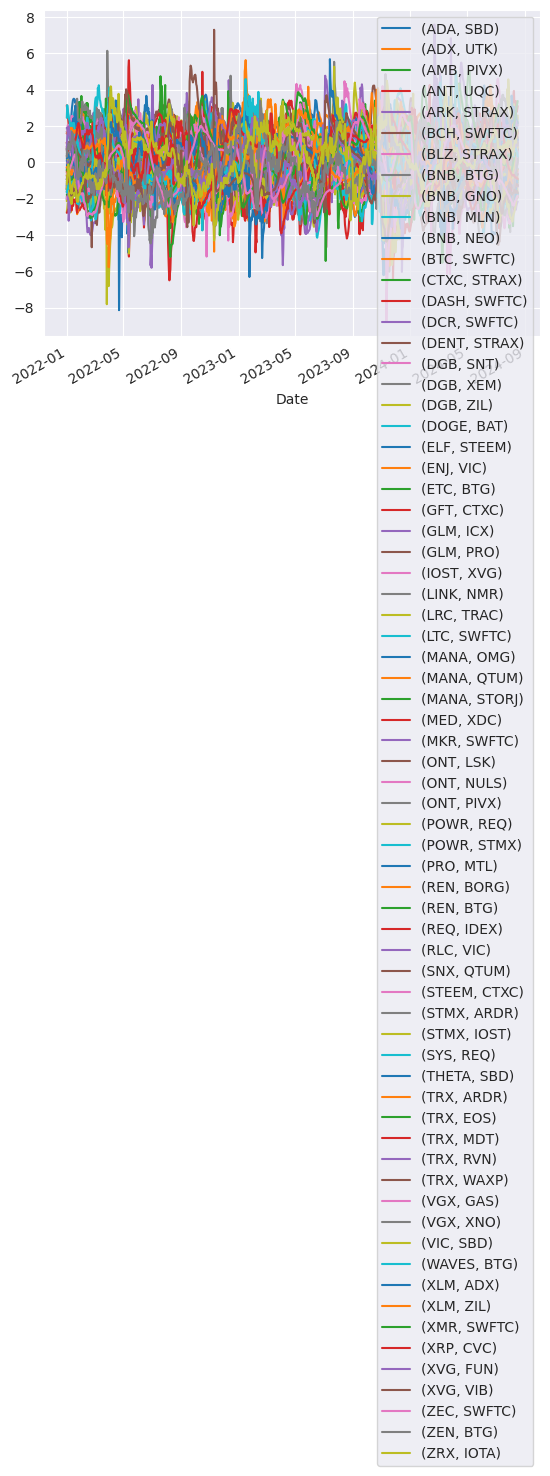

In [25]:
# plot the z-score
z_score_df = signal_df.xs('z_score', axis=1, level=1)
z_score_df.plot()

In [26]:
# portfolio construction
port = gen_port(signal_df, final_pairs, 0.2)
port.head()

,BTC,XRP,BNB,DOGE,ADA,TRX,LTC,LINK,BCH,EOS,...,UTK,PIVX,SYS,REQ,FUN,VIB,NULS,IDEX,MDT,BORG
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,-0.022301,-0.022301,0.022301,-0.022301,0.022301,-0.022301,0.0,0.0,0.022301,-0.029280,...,0.000000,-0.020228,-0.022301,0.018732,0.000000,0.0,0.023753,0.0,0.000000,-0.001165
2022-01-02,-0.021542,-0.021542,0.021542,-0.021542,0.021542,-0.021542,0.0,0.0,0.021542,-0.028204,...,0.000000,-0.019605,-0.021542,0.017419,0.028114,0.0,0.022795,0.0,0.000000,-0.001225
2022-01-03,-0.022096,-0.022096,0.022096,-0.022096,0.022096,-0.022096,0.0,0.0,0.022096,-0.028783,...,0.000000,-0.020233,-0.022096,0.017238,0.028801,0.0,0.023417,0.0,0.000000,-0.001317
2022-01-04,-0.022303,-0.022303,0.022303,-0.022303,0.022303,-0.022303,0.0,0.0,0.022303,-0.028844,...,0.000000,-0.020680,-0.022303,0.016826,0.029046,0.0,0.023344,0.0,0.000000,-0.001330
2022-01-05,-0.019778,-0.019778,0.019778,-0.019778,0.019778,-0.019778,0.0,0.0,0.019778,-0.025378,...,-0.005948,-0.018586,-0.019778,0.014441,0.025779,0.0,0.020333,0.0,0.053791,-0.001179


<Axes: xlabel='Date'>

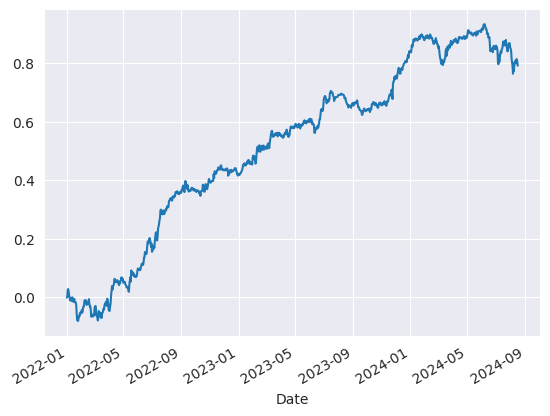

In [27]:
# Calculate out-of-sample daily returns
out_sample_ret = coins_ret.loc[start_of_out_sample:][port.columns]
strat_gross_ret = (port.shift() * out_sample_ret).sum(1)

# Calculate net returns
to = compute_turnover(port)
tcost_bps = 20  # (commissions + slippage)
strat_net_ret = strat_gross_ret.subtract(to * tcost_bps * 1e-4, fill_value=0)

strat_net_ret.cumsum().plot()

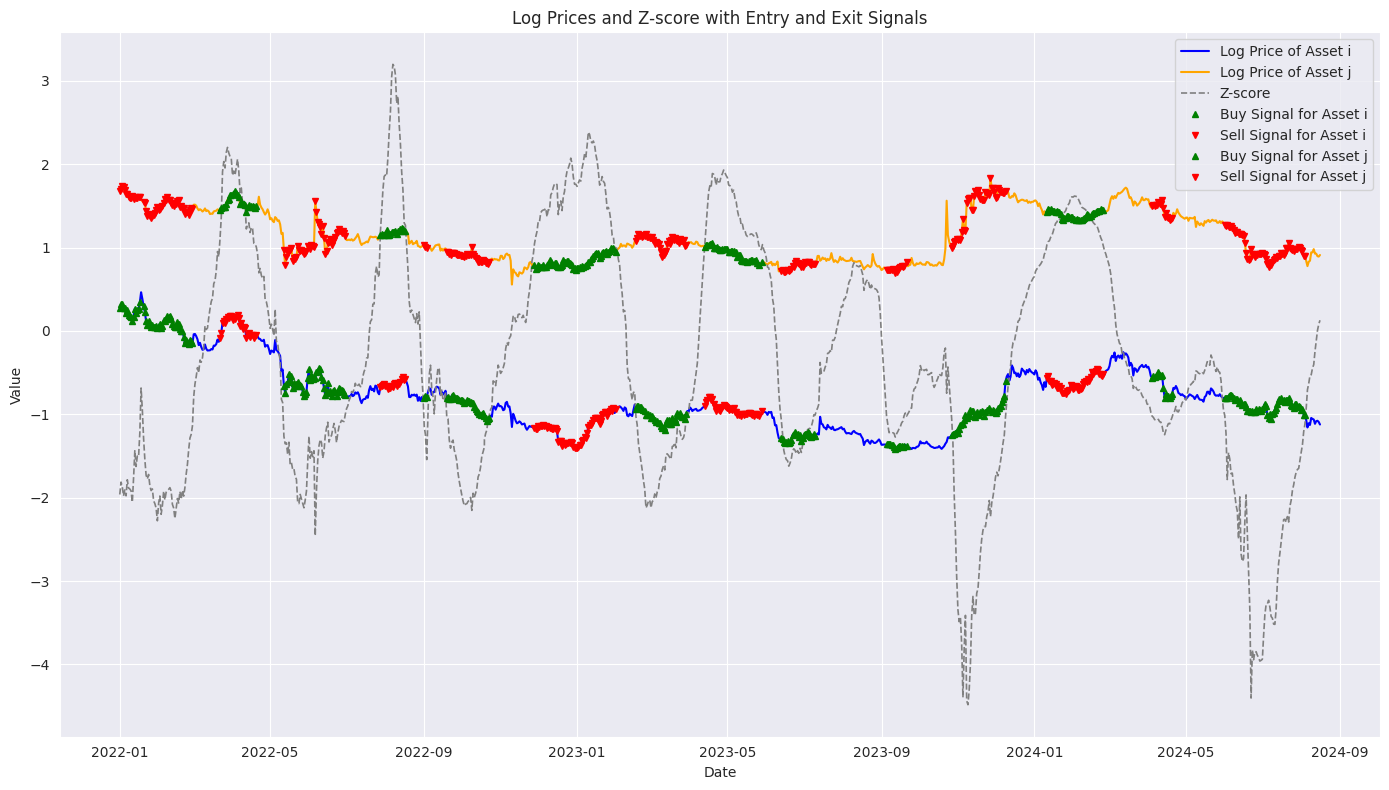

In [28]:
# select a random pair and visualize their log-prices and z-scores 
asset_i, asset_j = final_pairs[0] 
log_px_i = np.log(crypto_px.loc[start_of_out_sample:][asset_i])
log_px_j = np.log(crypto_px.loc[start_of_out_sample:][asset_j])
z_score = signal_df[(final_pairs[0], 'z_score')]

plot_with_signals(log_px_i, log_px_j, z_score)

We also compare the performance of our strategy against our benchmark, specifically a buy-and-hold strategy for Bitcoin. We will evaluate key metrics including alpha and beta, maximum drawdowns and maximum drawdown duration. 

In [29]:
buy_and_hold_btc = coins_ret['BTC'][start_of_out_sample:]
buy_and_hold_btc

Date
2022-01-01   -0.018482
2022-01-02    0.032307
2022-01-03   -0.008969
2022-01-04   -0.018065
2022-01-05   -0.012747
                ...   
2024-08-12   -0.034218
2024-08-13    0.009282
2024-08-14    0.021081
2024-08-15   -0.030726
2024-08-16   -0.018984
Name: BTC, Length: 960, dtype: float64

In [30]:
full_sample_ret = pd.DataFrame({
    'strat_ret': strat_net_ret,
    'buy_and_hold_btc': buy_and_hold_btc
})

full_sample_stats = compute_stats(full_sample_ret)
print(full_sample_stats)

                       avg       vol    sharpe  hit_rate
strat_ret         0.207747  0.138197  1.503272  0.531250
buy_and_hold_btc  0.160358  0.457895  0.350208  0.493737


<Axes: xlabel='Date'>

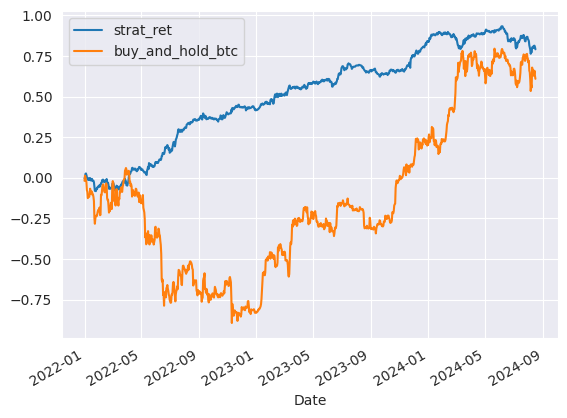

In [31]:
full_sample_ret.cumsum().plot()

In [32]:
corr = full_sample_ret.rolling(252).corr(full_sample_ret['buy_and_hold_btc'])
vol = full_sample_ret.rolling(252).std()

beta = (corr*vol).divide(vol['buy_and_hold_btc'], 0)

# Computing Point-in-Time Residual Returns
resid = full_sample_ret - beta.multiply(full_sample_ret['buy_and_hold_btc'], axis=0)
print(resid)
print(resid.corr())

# The information ratio
IR = resid.mean()/resid.std()*np.sqrt(252)
print(f"Information ratio is {IR['strat_ret']}")

            strat_ret  buy_and_hold_btc
Date                                   
2022-01-01        NaN               NaN
2022-01-02        NaN               NaN
2022-01-03        NaN               NaN
2022-01-04        NaN               NaN
2022-01-05        NaN               NaN
...               ...               ...
2024-08-12  -0.007699      6.938894e-18
2024-08-13   0.013555     -1.734723e-18
2024-08-14  -0.000260     -3.469447e-18
2024-08-15  -0.006771      6.938894e-18
2024-08-16  -0.013471      3.469447e-18

[960 rows x 2 columns]
                  strat_ret  buy_and_hold_btc
strat_ret          1.000000         -0.007923
buy_and_hold_btc  -0.007923          1.000000
Information ratio is 0.6345426373268191


The correlation of the residual returns with Bitcoin is 0.07, suggesting that the strategy captures true alpha

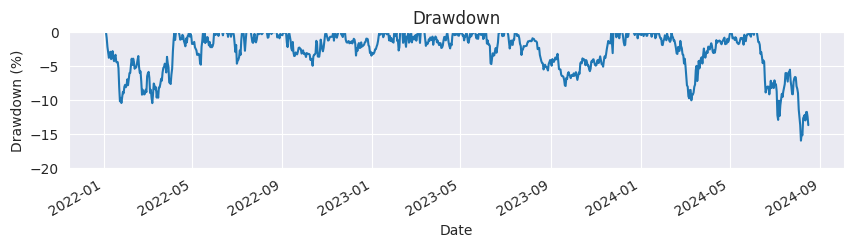

The max drawdown is -15.998689236849598


In [33]:
# Plot drawdown
# dd = drawdown(full_sample_ret['strat_ret'].cumsum())
dd = drawdown(full_sample_ret['strat_ret'])*100
plt.figure(figsize=(10, 2))
dd.plot()
plt.ylim(-20, 0)
plt.title('Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.show()
print(f"The max drawdown is {dd.min()}")

In [34]:
ddd = duration(full_sample_ret.cumsum())
ddd

,strat_ret,buy_and_hold_btc
Date,,
2022-01-01,0,0
2022-01-02,0,0
2022-01-03,0,1
2022-01-04,0,2
2022-01-05,1,3
...,...,...
2024-08-12,67,83
2024-08-13,68,84
2024-08-14,69,85


<Axes: xlabel='Date'>

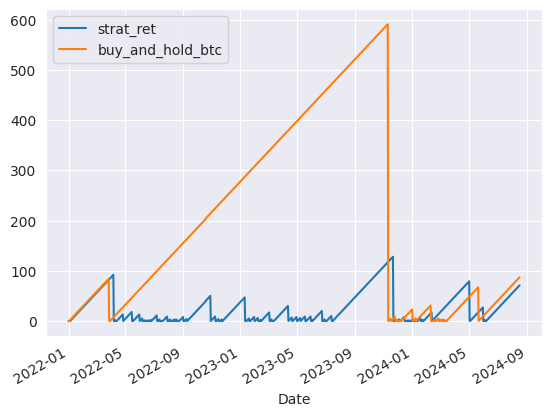

In [35]:
ddd.plot()

In [36]:
# maximum drawdown duration
ddd.max()

strat_ret           128
buy_and_hold_btc    591
dtype: object

**Final Result**

In [37]:
avg_return = full_sample_stats.loc['strat_ret', 'avg']
volatility = full_sample_stats.loc['strat_ret', 'vol']
sharpe = full_sample_stats.loc['strat_ret', 'sharpe']
hit_rate = full_sample_stats.loc['strat_ret', 'hit_rate']
max_drawdown = dd.min()
max_duration = ddd.max().loc['strat_ret']
holding_period = metrics_df.loc[0.1, 'Holding Period']
information_ratio = IR['strat_ret']

# Calculate strategy stats with formatted percentages and days
stats = final_results(avg_return, volatility, sharpe, hit_rate, max_drawdown, max_duration, holding_period, information_ratio)
print(stats)

                      strategy
Return (Ann.)           20.77%
Volatility (Ann.)       13.82%
Sharpe Ratio              1.50
Hit Rate                53.12%
Max Drawdown           -16.00%
Max Duration       128.00 days
Holding Period      19.92 days
Information Ratio         0.63


Overall, the cointegration strategy performs well in the crypto market. As a next step, we could explore combining this price/volume-based strategy with fundamental strategies. These strategies are likely to be synergistic and uncorrelated, potentially enhancing the overall performance of the portfolio.